In [24]:
import pandas as pd
import chordparser
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
from pySankey import sankey
warnings.filterwarnings("ignore")

---------------

### Definitions

In [25]:
cp = chordparser.Parser()
CE = chordparser.ChordEditor()
CRC = chordparser.ChordRomanConverter()

In [26]:
sharps_to_flats = {
    'C#': 'Db',
    'D#': 'Eb',
    'F#': 'Gb',
    'G#': 'Ab',
    'A#': 'Bb',
}

In [27]:
lower_base = {
    'C': 'B',
    'B': 'Bb',
    'Bb': 'A',
    'A': 'Ab',
    'Ab': 'G',
    'G': 'Gb',
    'Gb': 'F',
    'F': 'E',
    'E': 'Eb',
    'Eb': 'D',
    'D': 'Db',
    'Db': 'C'
}

In [28]:
number_of_songs = {'Country': 0,
                   'Electronic': 0,
                   'Pop': 0,
                   'Rock': 0}

In [29]:
# {'Country': ['major', 'minor', 'minor', ...], 'Pop': ...}
modes = {'Country': [],
        'Electronic': [],
        'Pop': [],
        'Rock': []}

In [30]:
# {'Country': {'IV': 30, 'V': 2, ...}, 'Pop': {...}, ...}
nodelists_sum = {'Country': {},
                 'Electronic': {},
                 'Pop': {},
                 'Rock': {}}

In [31]:
dataframes = {'Country': pd.DataFrame(columns=['from_roman', 'to_roman']),
              'Electronic': pd.DataFrame(columns=['from_roman', 'to_roman']),
              'Pop': pd.DataFrame(columns=['from_roman', 'to_roman']),
              'Rock': pd.DataFrame(columns=['from_roman', 'to_roman'])}

In [32]:
dataframes_all = {'Country': pd.DataFrame(columns=['from_roman', 'to_roman']),
                  'Electronic': pd.DataFrame(columns=['from_roman', 'to_roman']),
                  'Pop': pd.DataFrame(columns=['from_roman', 'to_roman']),
                  'Rock': pd.DataFrame(columns=['from_roman', 'to_roman'])}

In [33]:
nodelists = {}

----------------------

### Single song processing

In [34]:
def get_roman_dataframe(file):
    # dataframe
    df = pd.read_csv(file, delimiter='\t', skiprows=2, header=None)
    df.columns=['from', 'to']

    # signature
    with open(file, "r") as fin:
        signature = fin.readlines()[:2]
        
    base = re.split(':|\\n', signature[0])[1]
    capo = re.split(':|\\n', signature[1])[1]
    
    if capo == 'None':
        capo = 0
    else:
        capo = int(capo)

    # key and scale
    if('m' in base):
        mode = 'minor'
        base = base.replace('m', '')
    else:
        mode = 'major'
        
    if base in sharps_to_flats.keys() and base != df['from'][0].replace('m', ''):
        base = sharps_to_flats[base]  

    for i in range(capo):
        base = lower_base[base]

    key = cp.create_key(base, mode)

    df['from'] = df['from'].apply(lambda x: x.replace(')', '').replace('(', '').replace('-5', 'b5').replace('+5', '#5').replace('-', ''))#.replace('5', '').replace('-', ''))
    df['to'] = df['to'].apply(lambda x: x.replace(')', '').replace('(', '').replace('-5', 'b5').replace('+5', '#5').replace('-', ''))#.replace('5', '').replace('-', ''))

    # add mode to dict
    genre = file.split('/')[1]
    modes[genre].append(mode)

    # convert to roman
    if base in sharps_to_flats.keys():
        base = sharps_to_flats[base]  
        
    df['from_roman'] = df['from'].apply(lambda x: str(CRC.to_roman(CE.create_chord(x),key)))
    df['to_roman'] = df['to'].apply(lambda x: str(CRC.to_roman(CE.create_chord(x),key)))
    
    df = df.drop(columns=['from','to'])

    return df

In [35]:
def add_to_nodelist(df, genre):    
    all_chords = pd.unique(df.values.ravel('K'))
        
    for chord in all_chords:
        value_count = 0
        
        if chord in df.from_roman.values:
            value_count = df.from_roman.value_counts()[chord]

        # include last chord
        if (df.to_roman.iloc[-1]) == chord:
            value_count += 1

        # add appearances to nodelist
        if chord not in nodelists_sum[genre].keys():
            nodelists_sum[genre][chord] = 0
        nodelists_sum[genre][chord] += value_count
        

    return

In [36]:
def process_song(file):

    df = get_roman_dataframe(file)
    
    genre = file.split('/')[1]
    
    dataframes[genre] = dataframes[genre].append(df)
    add_to_nodelist(df, genre)

    number_of_songs[genre] += 1

### Genre processing

In [37]:
def create_nodelist(genre):
    df = pd.DataFrame([nodelists_sum[genre]])
    df = df.T.rename(columns={0: 'sum_appearance'})
    
    df['percent'] = df['sum_appearance'] / df['sum_appearance'].sum()
    df['average_appearance'] = df['sum_appearance'] / number_of_songs[genre]

    df = df.reset_index()
    df = df.rename(columns={'index': 'Id'})
    
    return df

In [38]:
def get_percentages(df, nodelist):

    df = df.groupby(df.columns.tolist(),as_index=False).size()
    df['percent'] = df['size'] / df['size'].sum()

    return df

--------------

## Main

### Process every song

In [39]:
directory = 'data/'

for subdir, dirs, files in os.walk(directory):
    for i, filename in enumerate(os.listdir(subdir)):
        f = os.path.join(subdir, filename)
        if os.path.isfile(f):
            df = process_song(f)

-----------------

# Markov Chain

In [40]:
def get_markov_dataframe(genre, steps, threshold):
    if (steps < 2 or steps > 4):
        return
    
    from_list = []
    to_list = []

    if (steps == 2):
        for i, row in dataframes[genre].iterrows():
            from_list.append(row.from_roman)
            to_list.append(row.to_roman)

        markov = pd.DataFrame({'from': from_list, 'to': to_list})

    if (steps == 3):
        to_list2 = []
        for i, row in dataframes[genre].iterrows():
            if i > 0:
                from_list.append(dataframes[genre].iloc[i-1].from_roman)
                to_list.append(row.from_roman)
                to_list2.append(row.to_roman)

        markov = pd.DataFrame({'from': from_list, 'to1': to_list, 'to2': to_list2})
    
    if(steps == 4):
        to_list2 = []
        to_list3 = []

        for i, row in dataframes[genre].iterrows():
            if i > 1:
                from_list.append(dataframes[genre].iloc[i-2].from_roman)
                to_list.append(dataframes[genre].iloc[i-1].from_roman)
                to_list2.append(row.from_roman)
                to_list3.append(row.to_roman)

        markov = pd.DataFrame({'from': from_list, 'to1': to_list, 'to2': to_list2, 'to3': to_list3})

    nodes_markov = create_nodelist(genre)
    df_markov = get_percentages(markov, nodes_markov)
    df_markov = df_markov[df_markov['percent'] > threshold]

    if (steps == 2):
        from_to = df_markov['from']
    if (steps == 3):
        from_to = df_markov['from'] + ' - ' + df_markov['to1']
        df_markov = df_markov.rename(columns={'to2': 'to'})
    if(steps == 4):
        from_to = df_markov['from'] + ' - ' + df_markov['to1'] + ' - ' + df_markov['to2']
        df_markov = df_markov.rename(columns={'to3': 'to'})

    df_markov['from_to'] = from_to

    return df_markov

In [41]:
def plot_markov(df):
    weight = df['percent'].values.astype(float)
    sankey.sankey(
        df['from_to'], df['to'], aspect=20,
        fontsize=20, leftWeight= weight, rightWeight=weight
    )
    fig = plt.gcf()
    fig.set_size_inches(40,40)
    fig.show()

----------------------

In [42]:
df

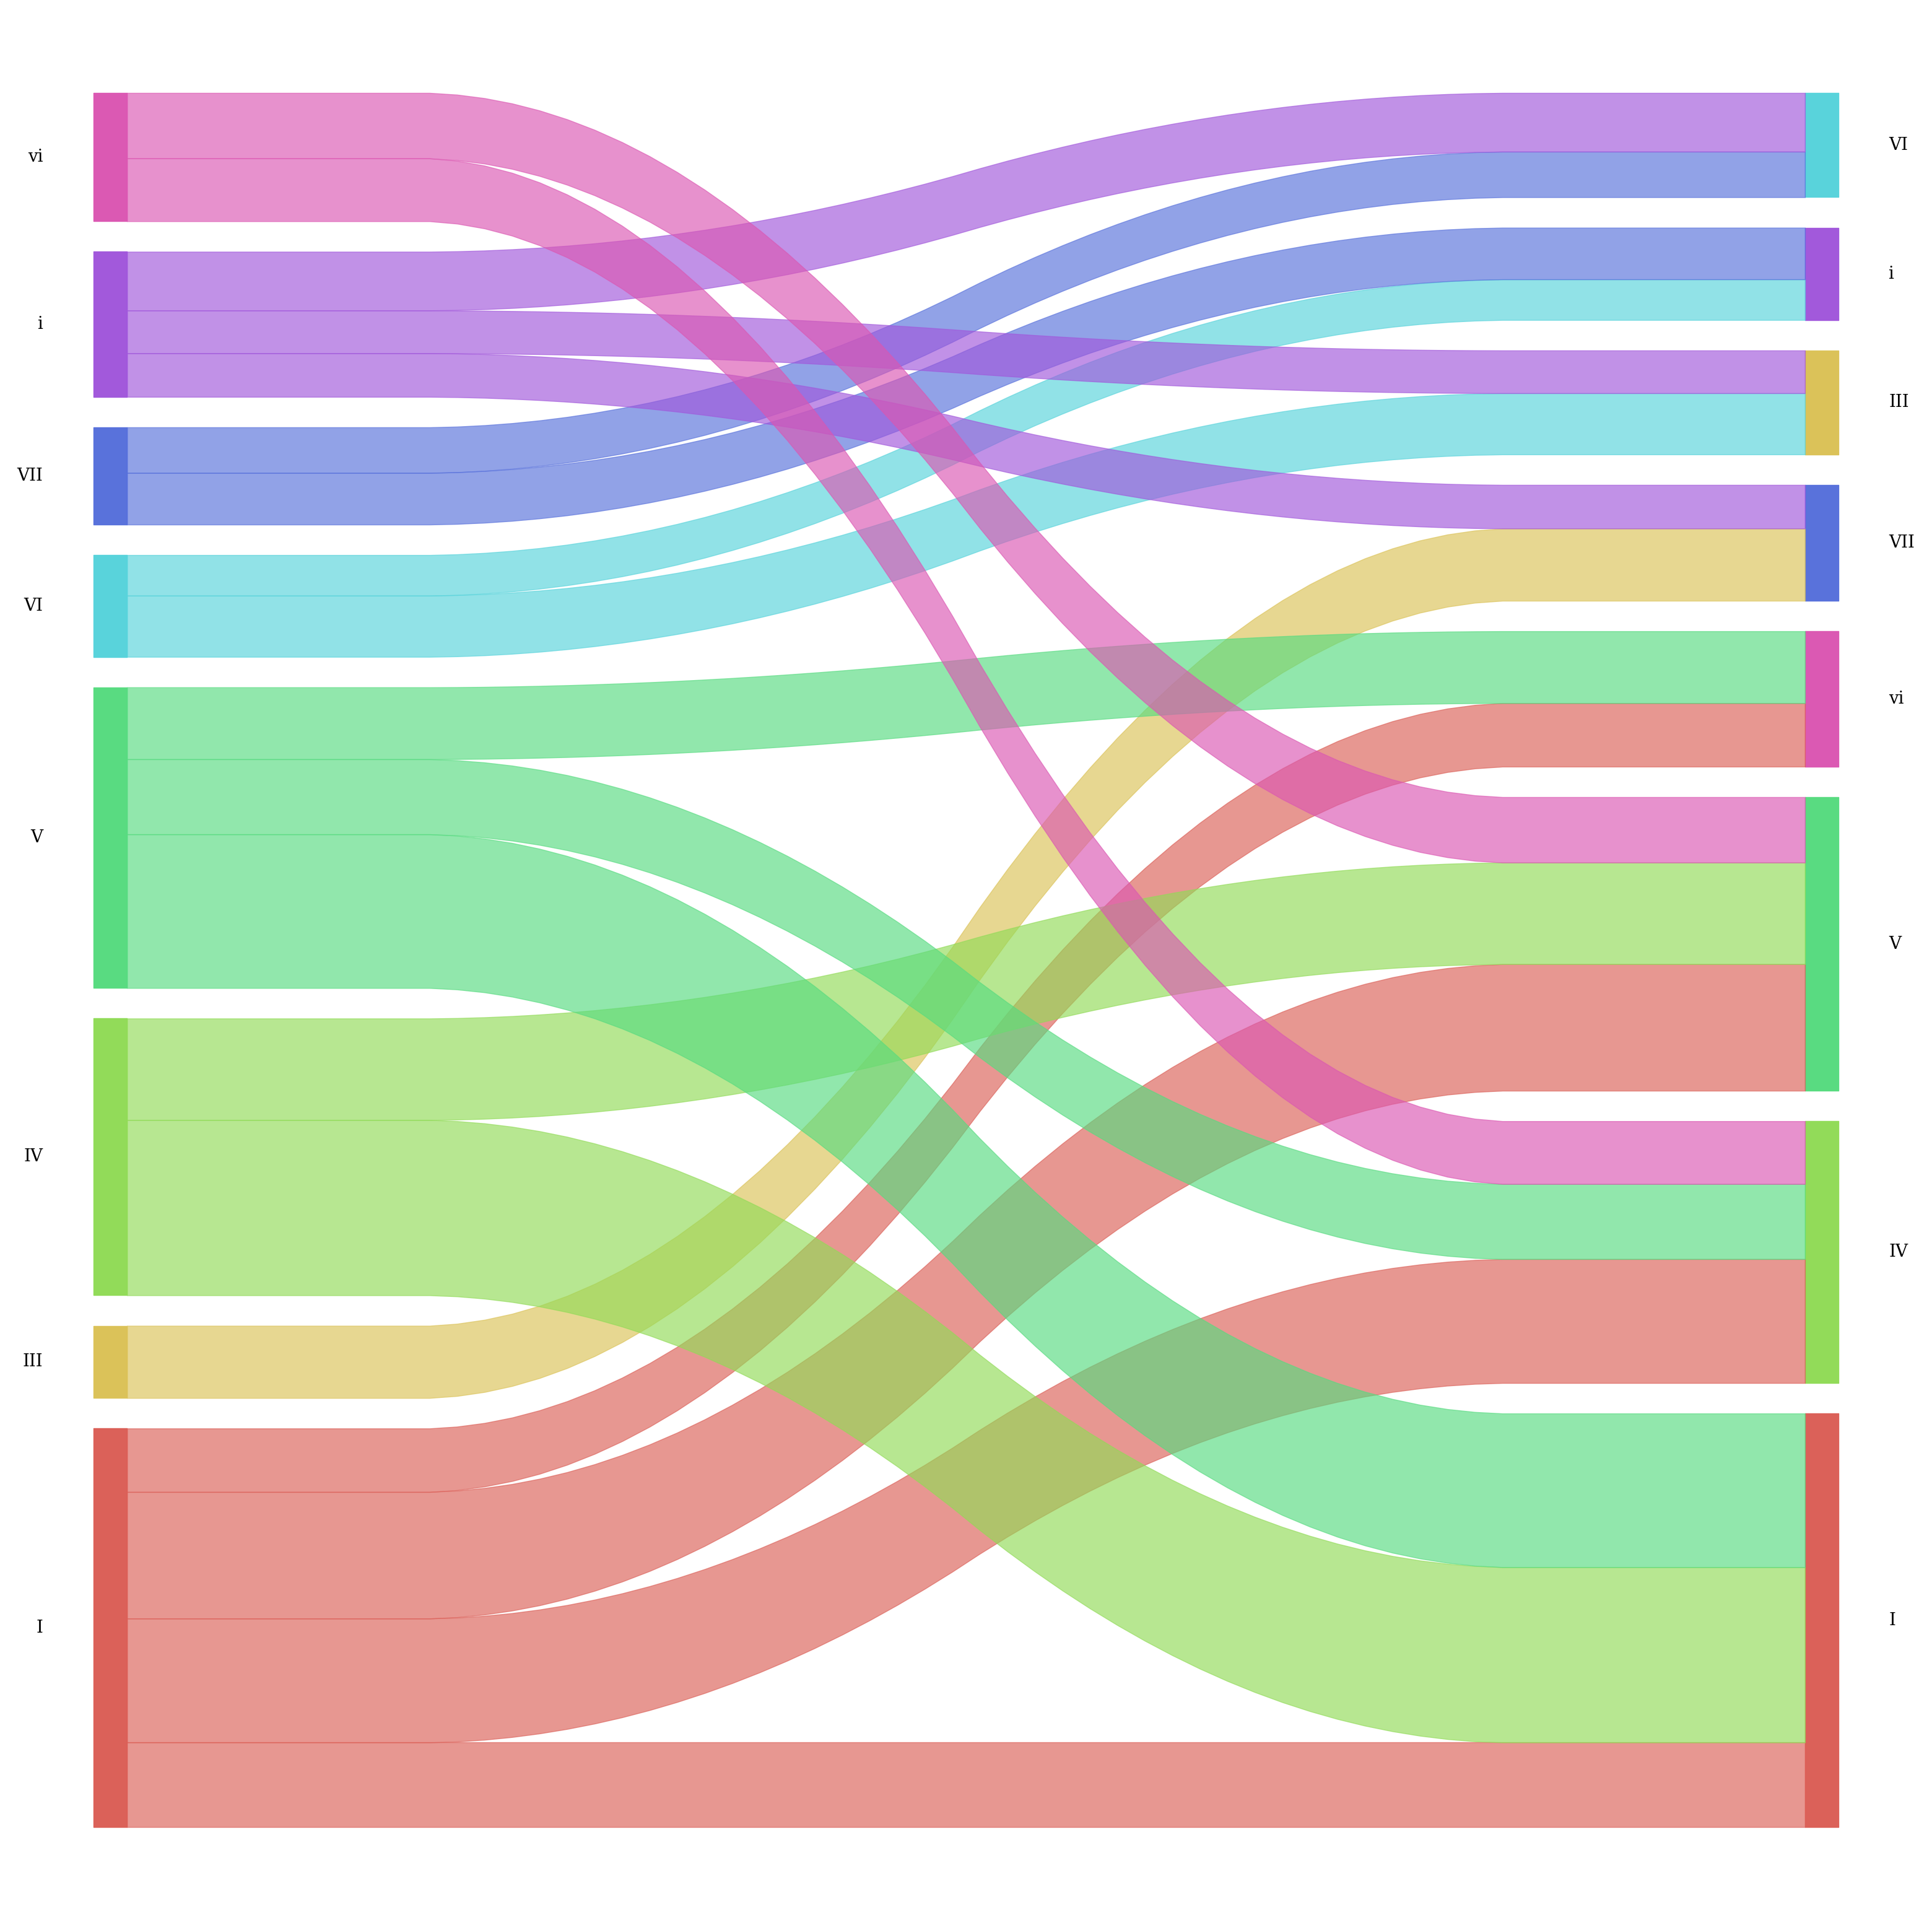

In [48]:
df = get_markov_dataframe('Rock', steps=2, threshold=0.01)
plot_markov(df)

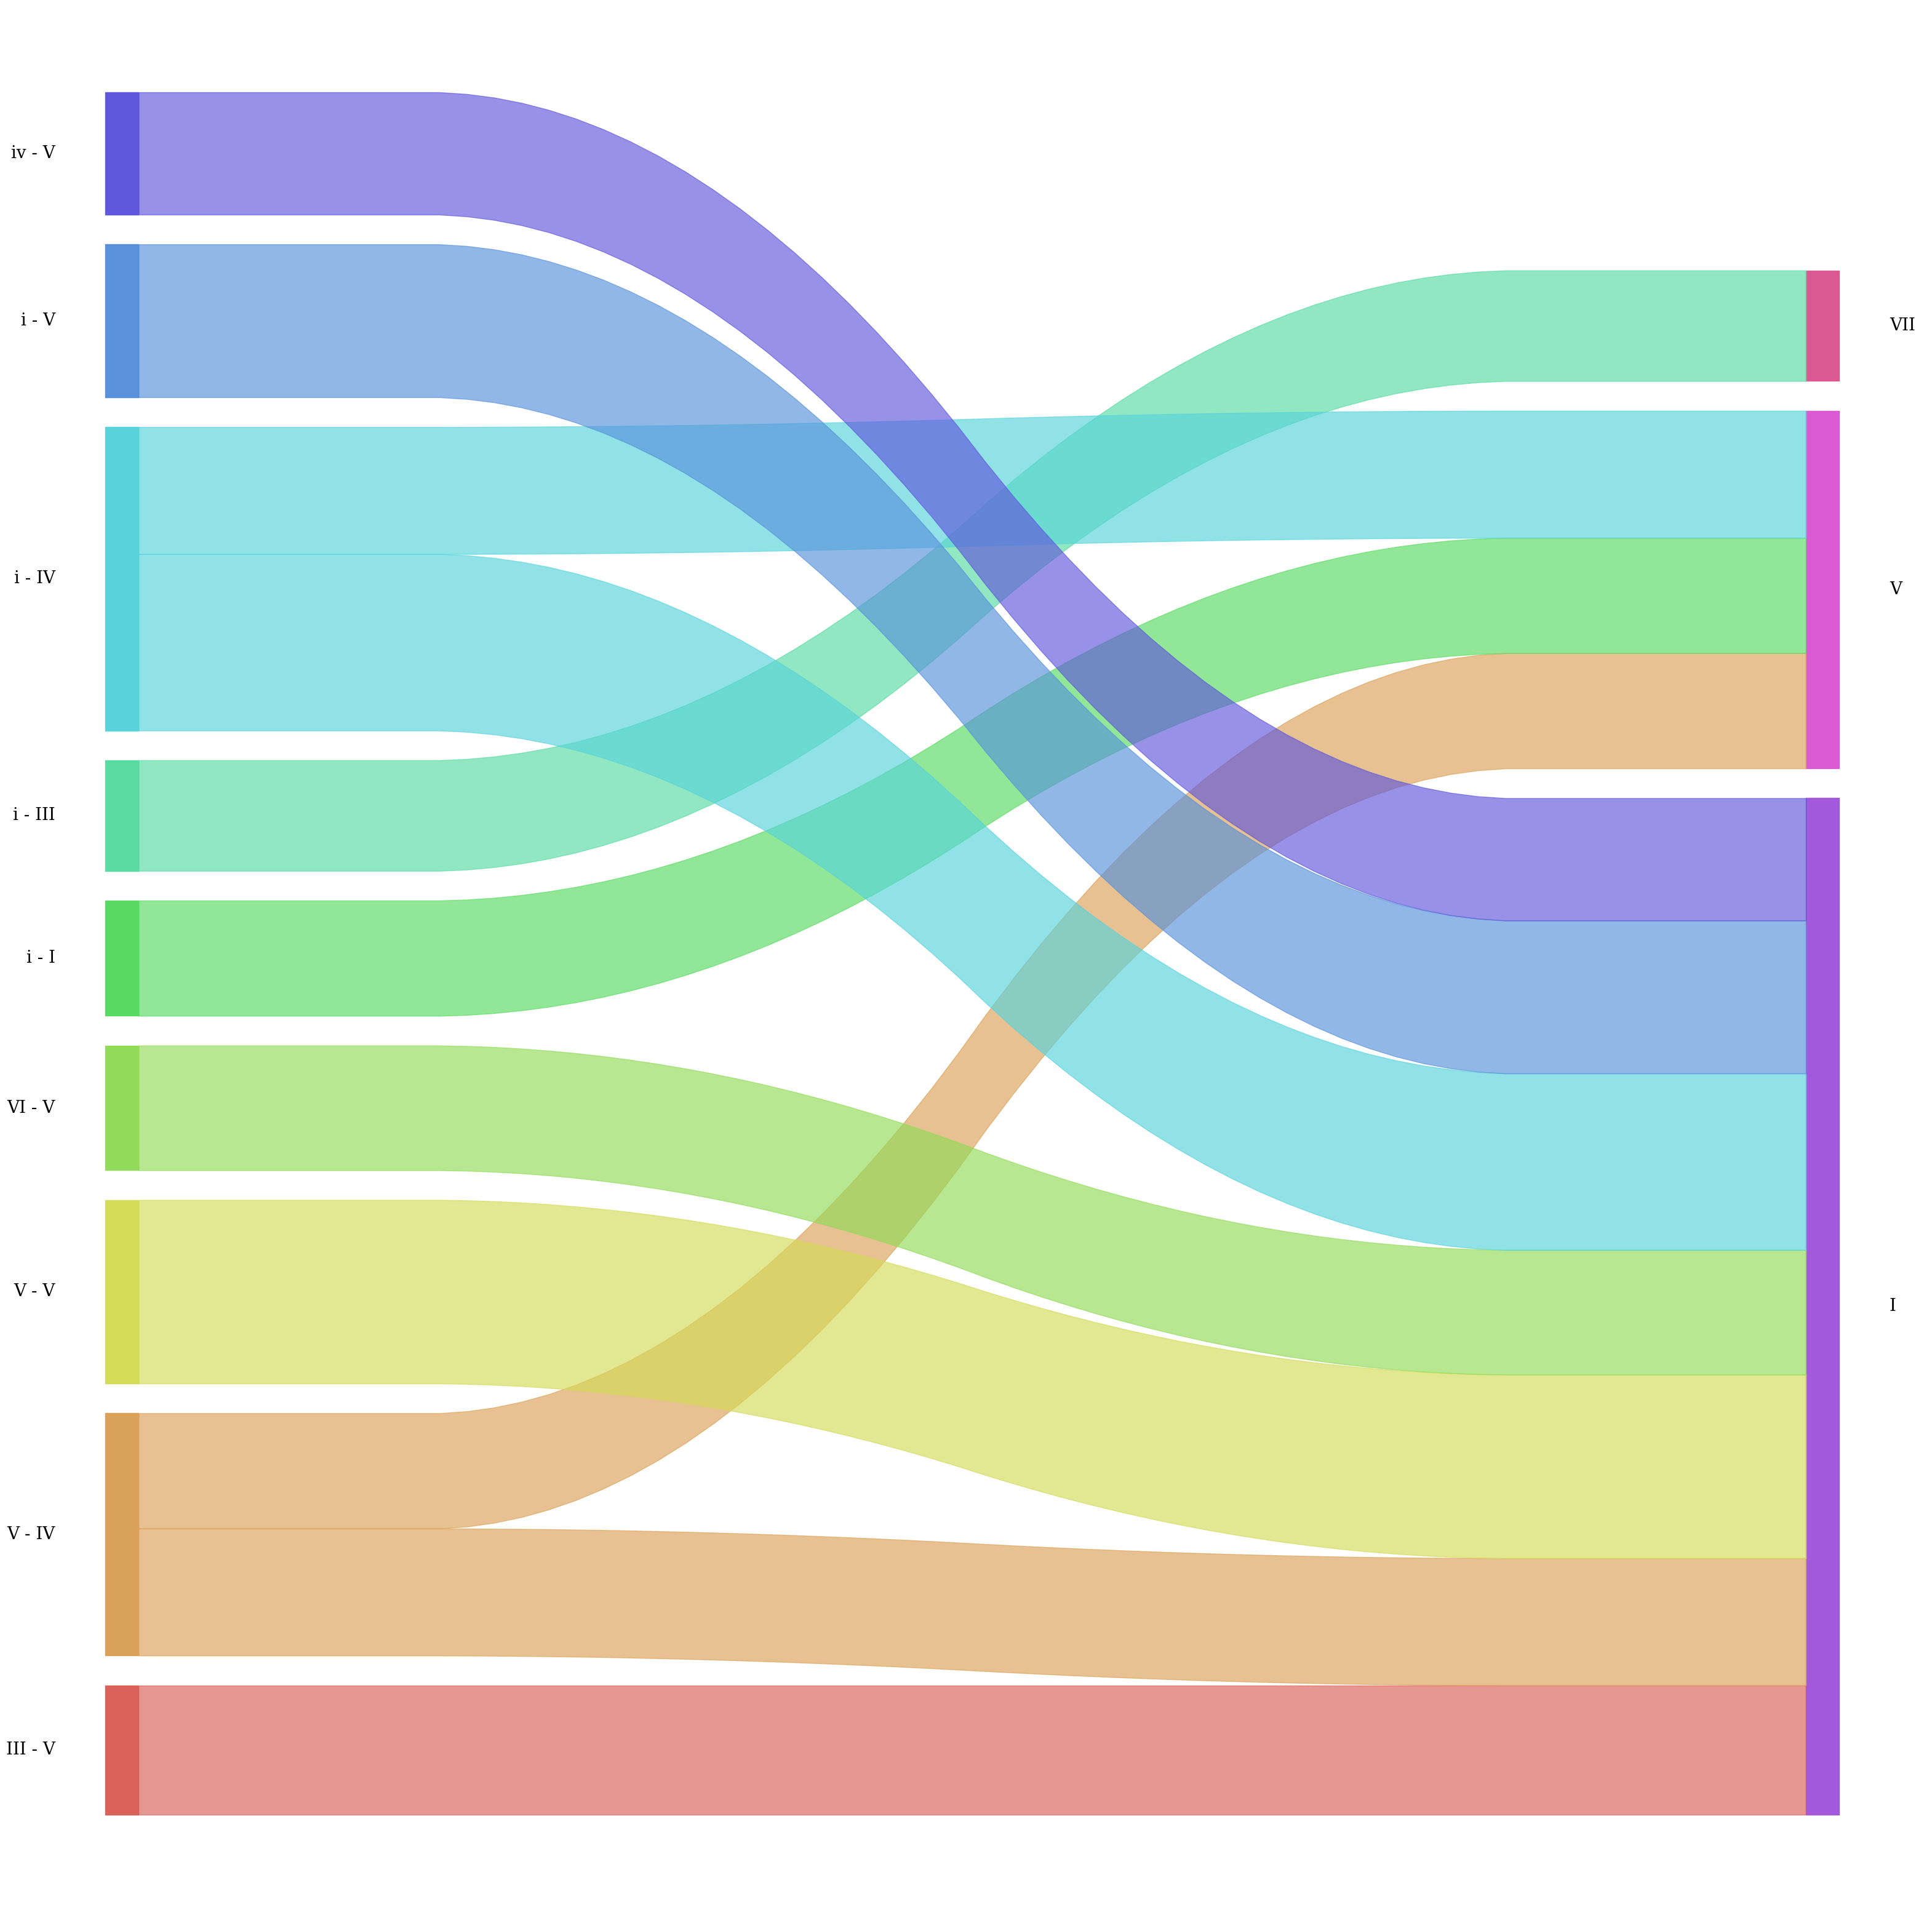

In [44]:
df = get_markov_dataframe('Pop', steps=3, threshold=0.005)
plot_markov(df)

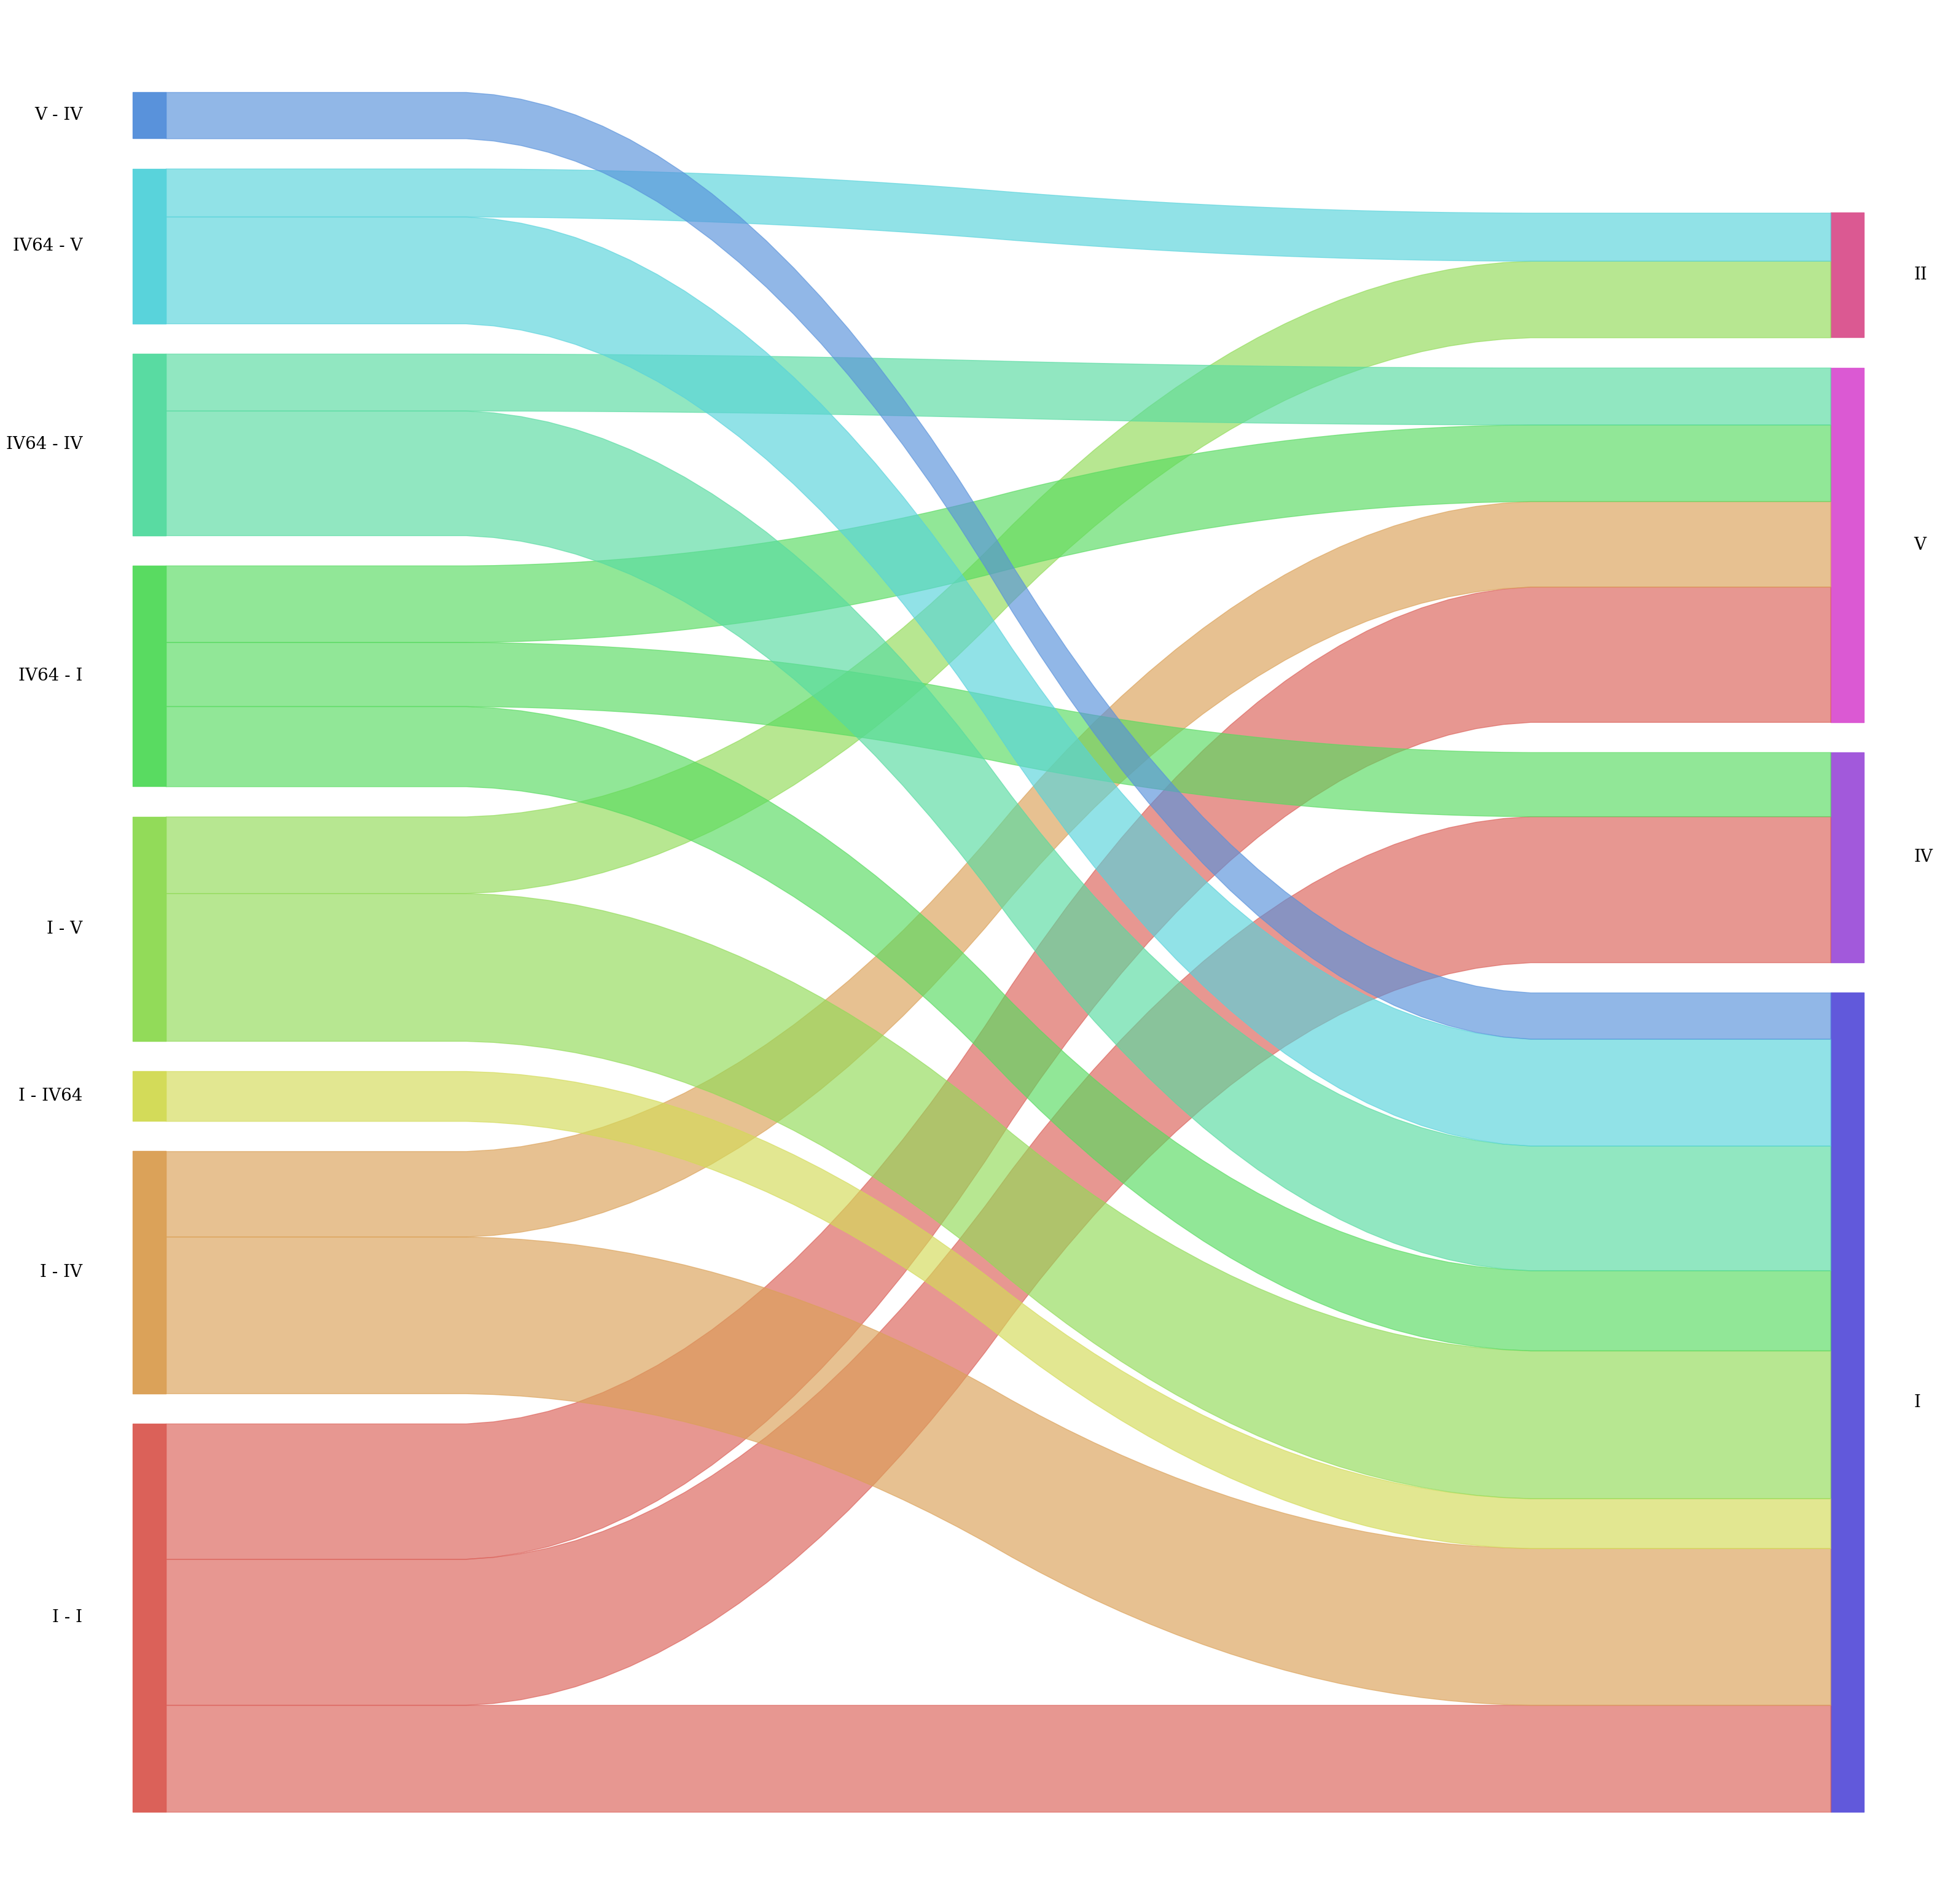

In [45]:
df = get_markov_dataframe('Country', steps=3, threshold=0.01)
plot_markov(df)

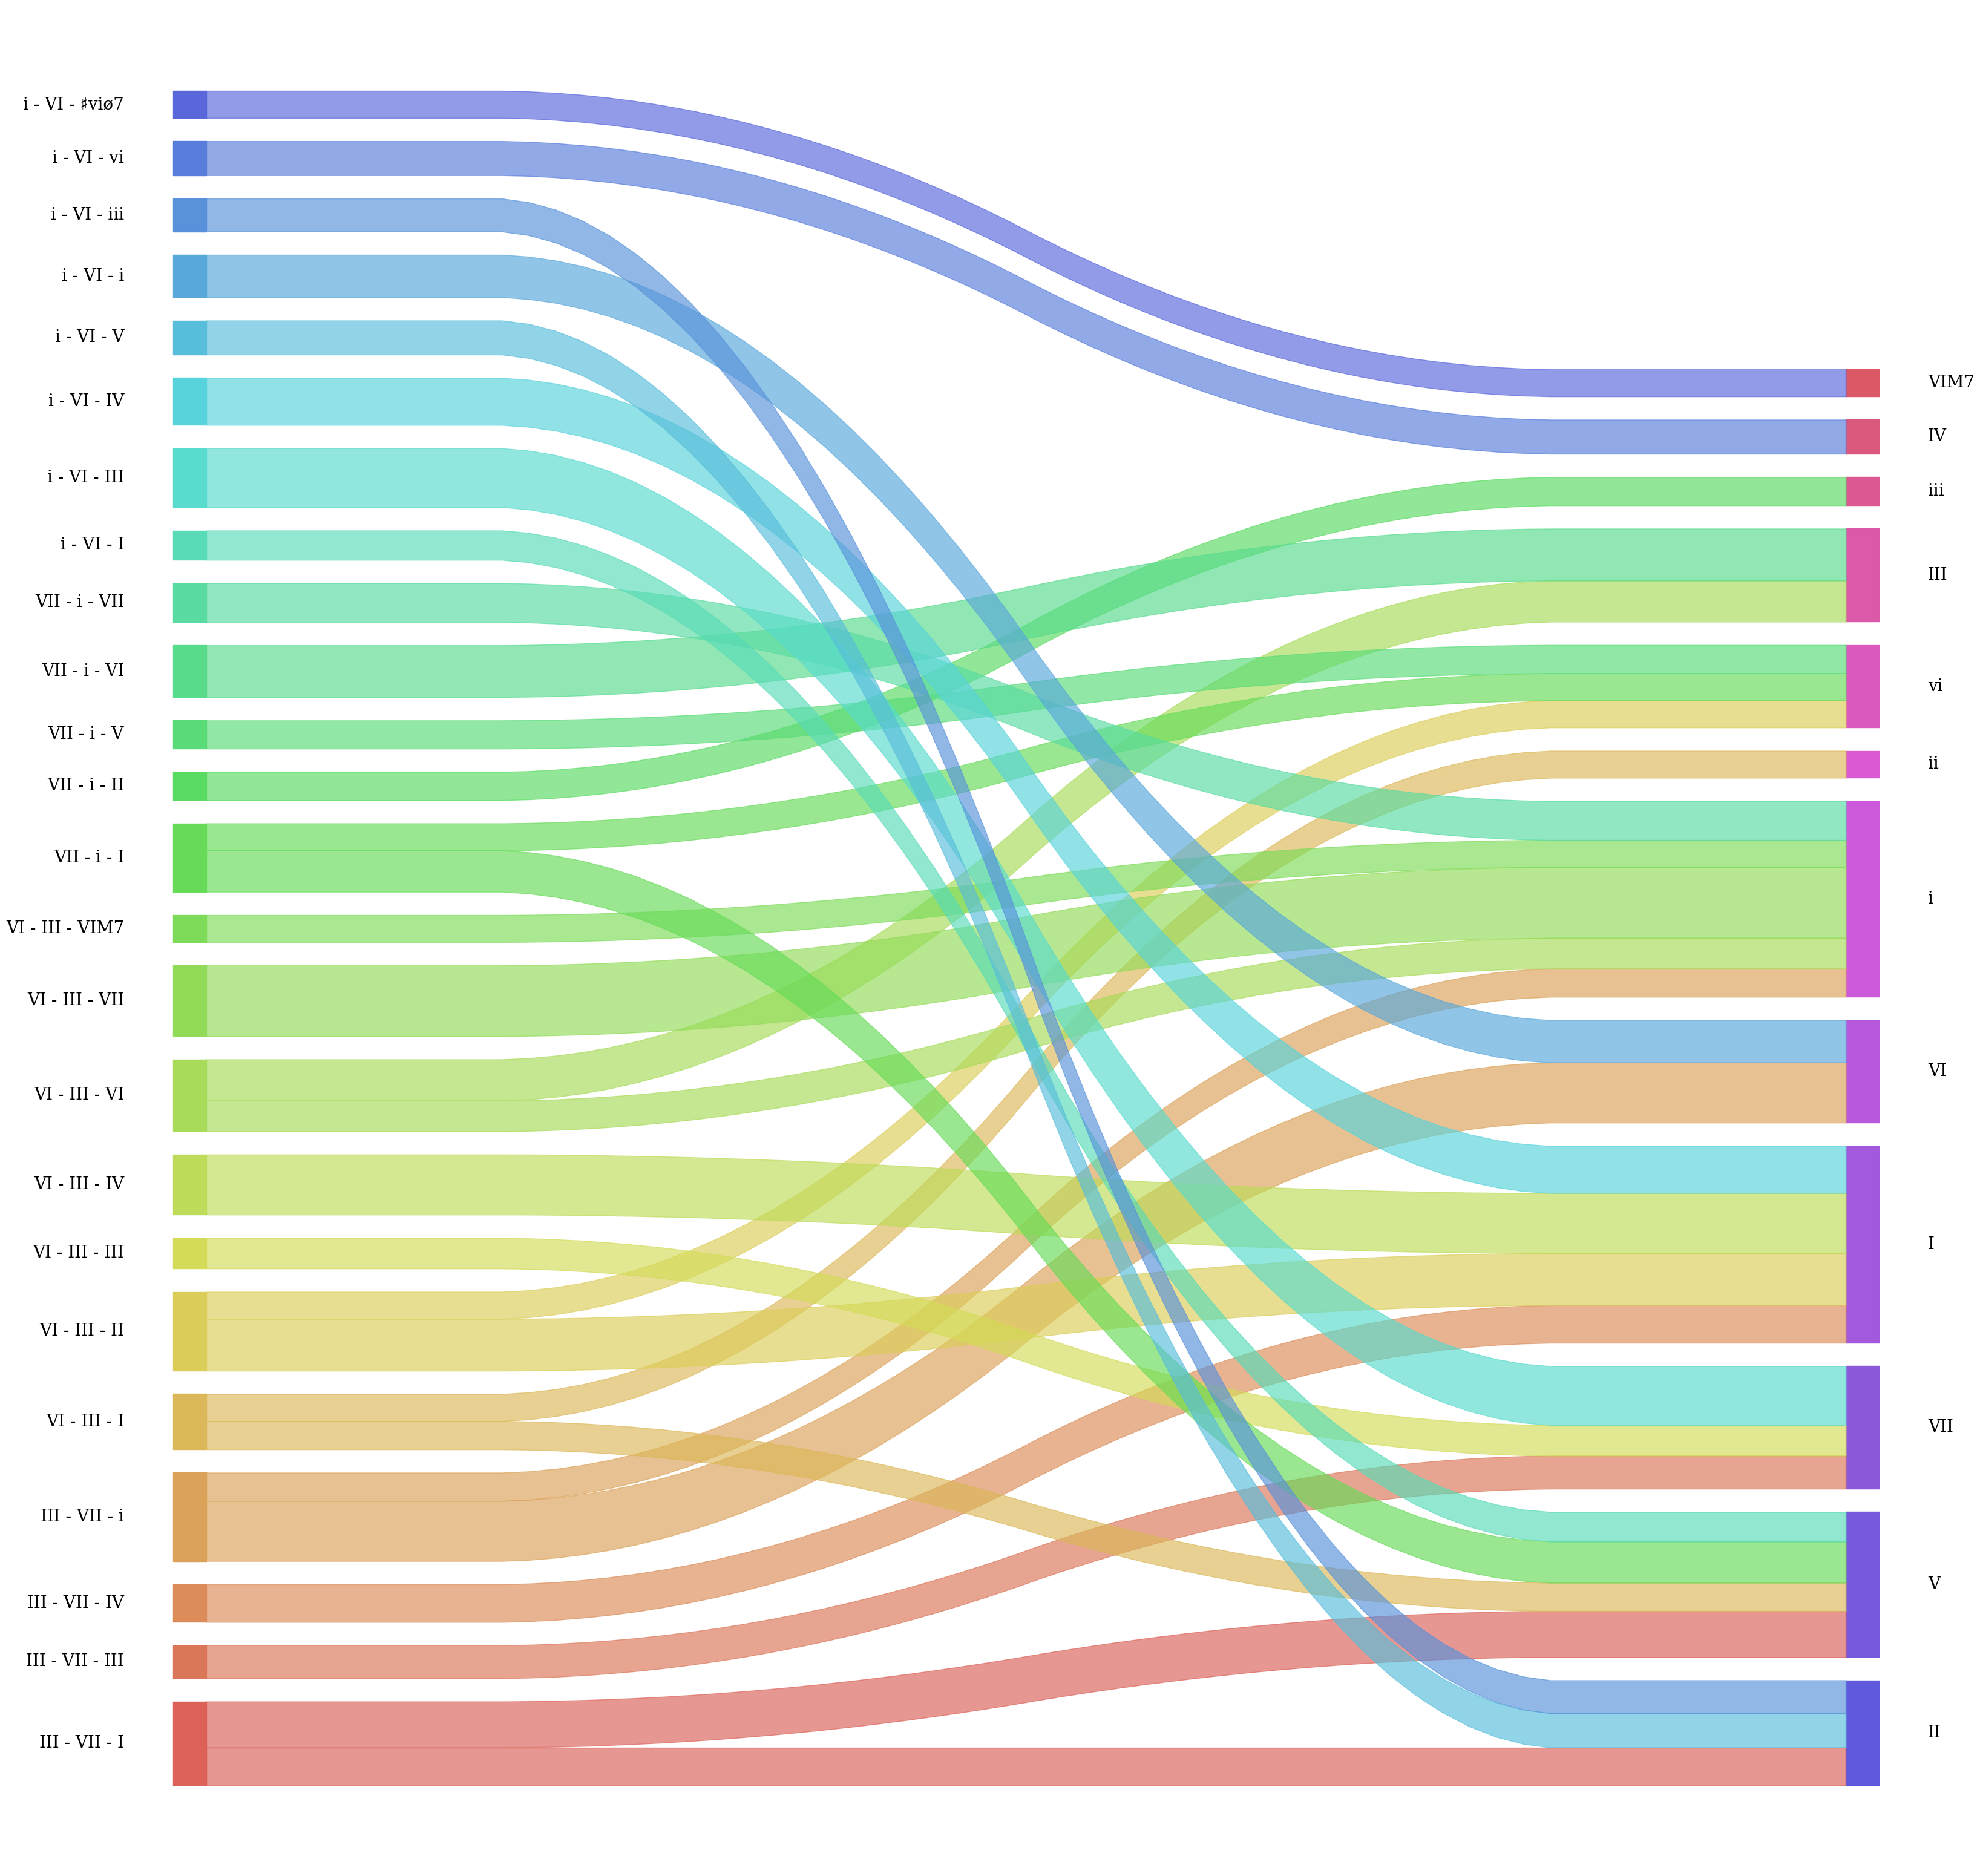

In [46]:
df = get_markov_dataframe('Electronic', steps=4, threshold=0.005)
plot_markov(df)